### Transfer Learnig (전이 학습)

In [ ]:
# cats_and_dogs classification model with InceptionV3
# train : 2000 images [cat(1000) + dog(1000)]  , size는 다름
# validation : 1000 images [cat(500) + dog(500)] , size는 다름

In [1]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Colab용 : Linux/GPU사용 
# !wget --no-check-certificate \
#     https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
#     -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

In [3]:
# ! mkdir tmp

In [4]:
# Google InceptionV3 pretrained model 가중치 다운로드, Windows용
_INCEPTION_URL = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
urllib.request.urlretrieve(_INCEPTION_URL, 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

('tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 <http.client.HTTPMessage at 0x7ff1513abd10>)

In [5]:
# 사전 훈련된 모델의 가중치 불러오기
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weights_file = 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                               include_top = False,
                               weights = None)

pre_trained_model.load_weights(local_weights_file)

print(len(pre_trained_model.layers))  # 311

# 사전 훈련 계층의 가중치의 훈련(학습) 가능 여부를 설정 : False(학습 안함) , 고정
for layer in pre_trained_model.layers: # 311회 반복
    layer.trainable = False
    
pre_trained_model.summary()

311
Model: "inception_v3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                   

In [6]:
# 마지막 층 출력 확인하기(마지막 출력 층을 선택)
#  mixed7 (Concatenate)  :    (None, 7, 7, 768)
last_layer = pre_trained_model.get_layer('mixed7')
print('last layer output shape: ',last_layer.output_shape) # (None, 7, 7, 768)
last_output = last_layer.output

last layer output shape:  (None, 7, 7, 768)


In [7]:
# layer의 층 번호 구하기
# for i,layer in enumerate(pre_trained_model.layers): # 311회 반복
#     if(layer.name == 'mixed7'):
#         print(i+1)

# layer의 층 번호 구하기
pre_trained_model.layers.index(pre_trained_model.get_layer('mixed7')) + 1

229

In [8]:
# 모델 구성  : pre_trained model layer(229)  + 4  --> 233 layers
# (1) Flatten layer
x = layers.Flatten()(last_output)
# (2) FC layer
x = layers.Dense(1024,activation='relu')(x)
# (3) Dropout layer
x = layers.Dropout(0.2)(x)
# (4) Outpu layer : sigmoid , 2진 분류
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)

model.compile(optimizer=RMSprop(learning_rate=0.0001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
                                                                                              

In [9]:
# cats_and_dogs 데이터셋 다운로드 , Windows용  ,현재 경로 아래에 tmp/ 디렉토리가 있어야 가능
_TRAIN_URL = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
urllib.request.urlretrieve(_TRAIN_URL, 'tmp/cats_and_dogs_filtered.zip')

('tmp/cats_and_dogs_filtered.zip', <http.client.HTTPMessage at 0x7ff0ec499b90>)

In [10]:
# 압축 해제
local_zip = 'tmp/cats_and_dogs_filtered.zip'
zip_ref = zipfile.ZipFile(local_zip,'r')
zip_ref.extractall('tmp/')
zip_ref.close()

In [11]:
# 이미지 데이터 경로 설정
import os

base_dir = 'tmp/cats_and_dogs_filtered'

train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')

# Directory with our training cat/dog pictures
train_cats_dir = os.path.join(train_dir, 'cats')
train_dogs_dir = os.path.join(train_dir, 'dogs')

# Directory with our validation cat/dog pictures
validation_cats_dir = os.path.join(validation_dir, 'cats')
validation_dogs_dir = os.path.join(validation_dir, 'dogs')

train_cat_fnames = os.listdir( train_cats_dir )
train_dog_fnames = os.listdir( train_dogs_dir )

### 이미지 증강 구현

In [12]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(
                  train_dir,
                  target_size=(150,150),
                  batch_size=20,
                  class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
                  validation_dir,
                  target_size=(150,150),
                  batch_size=20,
                  class_mode='binary')

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [13]:
# 학습  : Colab 약 6~7분 소요
history = model.fit(train_generator,
                   steps_per_epoch=100,
                   epochs=20,
                   validation_data=validation_generator,
                   validation_steps=50,
                   verbose=1)

Epoch 1/20
100/100 [==============================] - 33s 217ms/step - loss: 0.3096 - accuracy: 0.8770 - val_loss: 0.1251 - val_accuracy: 0.9570
Epoch 2/20
100/100 [==============================] - 19s 193ms/step - loss: 0.2317 - accuracy: 0.9140 - val_loss: 0.0993 - val_accuracy: 0.9610
Epoch 3/20
100/100 [==============================] - 19s 194ms/step - loss: 0.1861 - accuracy: 0.9275 - val_loss: 0.0876 - val_accuracy: 0.9670
Epoch 4/20
100/100 [==============================] - 22s 217ms/step - loss: 0.1961 - accuracy: 0.9315 - val_loss: 0.1246 - val_accuracy: 0.9560
Epoch 5/20
100/100 [==============================] - 20s 198ms/step - loss: 0.1794 - accuracy: 0.9340 - val_loss: 0.1028 - val_accuracy: 0.9650
Epoch 6/20
100/100 [==============================] - 24s 240ms/step - loss: 0.1892 - accuracy: 0.9340 - val_loss: 0.0965 - val_accuracy: 0.9630
Epoch 7/20
100/100 [==============================] - 19s 192ms/step - loss: 0.1662 - accuracy: 0.9390 - val_loss: 0.0998 - val_ac

In [14]:
### 학습 결과 시각화

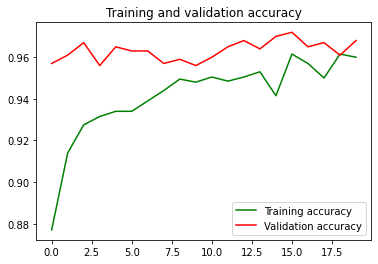

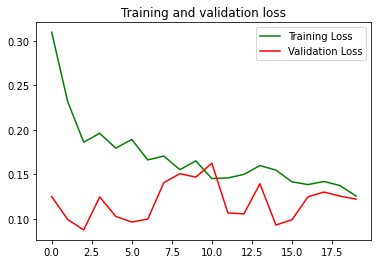

In [15]:
import matplotlib.pyplot as plt
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [ ]:
#  결과 : InceptionV3 pretrained model 사용 시 validation의 정확도가 크게 향상됨
#  val_accuracy: 0.8140 ---> val_accuracy: 0.9680